In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
characters = sorted(list(set("".join(words))))

stoi = {c: i + 1 for i, c in enumerate(characters)}
stoi["."] = 0
itos = {i: c for c, i in stoi.items()}

In [5]:
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:

# build the dataset

block_size = 3 # context length
X, Y = [], []
for w in words[:2]:
  
  print(w)
  context = [0] * block_size # 0 is padding index so
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop the first and append the next character

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .


In [7]:

# build the dataset

block_size = 3 # context length
X, Y = [], []
for w in words[:5]:
  
  # print(w)
  context = [0] * block_size # 0 is padding index so
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop the first and append the next character
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [8]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [9]:
for x, y in zip(X[:5], Y[:5]):
    print(f"Input: {x} Target: {y}")

Input: tensor([0, 0, 0]) Target: 5
Input: tensor([0, 0, 5]) Target: 13
Input: tensor([ 0,  5, 13]) Target: 13
Input: tensor([ 5, 13, 13]) Target: 1
Input: tensor([13, 13,  1]) Target: 0


### Embedding

In [10]:
C = torch.rand((27, 2))

In [11]:
C[5]

tensor([0.7510, 0.0025])

In [12]:
F.one_hot(torch.tensor([5]), num_classes=27).float() @ C # we will get the same as C[5] we are just picking the 5th row

tensor([[0.7510, 0.0025]])

In [13]:
C[[1, 2, 3]] # flexible

tensor([[0.0450, 0.0934],
        [0.0475, 0.4573],
        [0.5323, 0.3408]])

In [14]:
C[X].shape # for total 32 input size we have 3 ngram and for each token we get 2 dim embedding

torch.Size([32, 3, 2])

In [15]:
X[2]

tensor([ 0,  5, 13])

In [16]:
C[[0, 5, 13]], C[X][2] # same because in C we are directly picking the 0th 5th and 13th index where as in C[X] we are picking the embedding for the 2nd data point which has 0 5 and 13 index so they are same

(tensor([[0.9116, 0.4928],
         [0.7510, 0.0025],
         [0.5793, 0.6894]]),
 tensor([[0.9116, 0.4928],
         [0.7510, 0.0025],
         [0.5793, 0.6894]]))

In [17]:
emb = C[X] # 32, 3, 2

### Creating NN

In [18]:
W1 = torch.randn((6, 100)) # input 6 and output 100
b1 = torch.randn(100)

In [19]:
emb[:, 0, :].shape # embedding of just first character of all training data

torch.Size([32, 2])

In [20]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape # concat all three point each of 2 dimension of all three data

torch.Size([32, 6])

In [21]:
torch.cat(torch.unbind(emb, 1),1).shape # this will now work for any n gram automatically

torch.Size([32, 6])

In [22]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [23]:
a.view(6,3)

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]])

In [24]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [25]:
a.storage() # always a 1 dim tensor at memory

C:\Users\acer\AppData\Local\Temp\ipykernel_4824\2927268024.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage() # always a 1 dim tensor at memory


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [26]:
emb.shape

torch.Size([32, 3, 2])

In [27]:
# emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1) They are same

In [28]:
h = emb.view(-1, 6) @ W1 + b1 # first dim is inferred
# here b1 is brodcasted from 100 to [1, 100] to match [32, 100]

In [29]:
h.shape # output of hidden layer for all 32 items we get 100 different output

torch.Size([32, 100])

In [30]:
W2 = torch.randn((100, 27)) # weight of layer
b2 = torch.randn(27) # our vocab size

In [31]:
logits = h @ W2 + b2

In [32]:
logits = logits.exp()

In [33]:
probs = logits / logits.sum(1, keepdims=True)

In [34]:
probs.shape

torch.Size([32, 27])

In [35]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [36]:
Y # true label

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [37]:
probs[[0, 1], [5, 13]] # this means for first and second data point in our data what has the model assigned the probability 
# we know that by indexing the probability model has assigned to the neuron that was supposed to be maximum probability

tensor([2.3941e-24, 1.3749e-05])

In [38]:
probs[torch.arange(32), Y] # probability predicted at the correct label position of the target label

tensor([2.3941e-24, 1.3749e-05, 8.3223e-04, 6.7960e-12, 1.6577e-03, 4.2098e-26,
        1.7589e-14, 3.4875e-08, 8.7525e-03, 2.2313e-07, 1.8299e-05, 6.3772e-01,
        2.6565e-04, 1.1615e-10, 3.9217e-02, 7.2620e-01, 2.8625e-10, 1.2326e-20,
        1.2098e-04, 7.2682e-20, 4.4310e-14, 1.9262e-15, 3.9048e-12, 8.8361e-04,
        6.3963e-01, 2.3261e-20, 1.8349e-23, 9.9287e-08, 5.6160e-08, 7.2490e-15,
        3.7774e-17, 9.8927e-01])

In [39]:
loss = -probs[torch.arange(32), Y].log().mean() # average negative log likelihood lower the better

In [40]:
loss

tensor(21.8185)

### Everything till now

In [41]:

# build the dataset

block_size = 3 # context length
X, Y = [], []
for w in words:
  
  # print(w)
  context = [0] * block_size # 0 is padding index so
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop the first and append the next character
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [42]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [43]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [44]:
sum(p.nelement() for p in parameters)

3481

In [45]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(len(X)), Y].log().mean()
loss

tensor(19.5052)

In [46]:
F.cross_entropy(logits, Y)

tensor(19.5052)

In [47]:
for p in parameters:
    p.requires_grad = True

In [48]:
torch.linspace(0.01, 1, 10)

tensor([0.0100, 0.1200, 0.2300, 0.3400, 0.4500, 0.5600, 0.6700, 0.7800, 0.8900,
        1.0000])

In [49]:
for _ in range(10):
    # forward propagation
    embedding = C[X]
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward propagation
    for p in parameters:
        p.grad = None
    loss.backward()
# update
    for p in parameters:
        p.data += p.grad * -0.01 # if exploding decrease if reducing error by less increase

19.505229949951172
19.139127731323242
18.824243545532227
18.554031372070312
18.313011169433594
18.091293334960938
17.884031295776367
17.688785552978516
17.504188537597656
17.329423904418945


In [50]:
logits.max(1)

torch.return_types.max(
values=tensor([16.8542, 20.2968, 24.9531,  ..., 18.8934, 13.8314, 12.8948],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 10,  9,  ..., 10, 11, 17]))

### batching the train data

In [51]:
torch.randint(0, 5, (32, )) # between 0 and 5 make 32 data

tensor([0, 3, 1, 4, 3, 1, 1, 2, 0, 2, 3, 2, 3, 1, 1, 4, 3, 1, 0, 4, 4, 2, 4, 0,
        0, 1, 3, 3, 0, 2, 3, 3])

In [52]:
for _ in range(1000):
    # forward propagation
    ix = torch.randint(0, X.shape[0], (32, ))
    
    embedding = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward propagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += p.grad * -0.1
        
print(loss.item())

2.593179941177368


It is better to approximate gradient and make more steps ( like in one epoch multiple iteration) than to update gadient all at one (without batching data)

In [53]:
emb = C[X] # here doing on all data at once for 1 time
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss 

tensor(2.7331, grad_fn=<NllLossBackward0>)

### identifying the correct learning rate

In [54]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre # 0.001 to 1

In [55]:
lrs[:10]

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011])

In [56]:
lri = []
lossi = []
expl = []

for i in range(1000):
    # forward propagation
    ix = torch.randint(0, X.shape[0], (32, ))
    
    embedding = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward propagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i] # get learning rate different according to epoch
    for p in parameters:
        p.data += -lr * p.grad
        
    lri.append(lrs[i])
    expl.append(lre[i])
    lossi.append(loss.item())
        
print(loss.item())

10.251313209533691


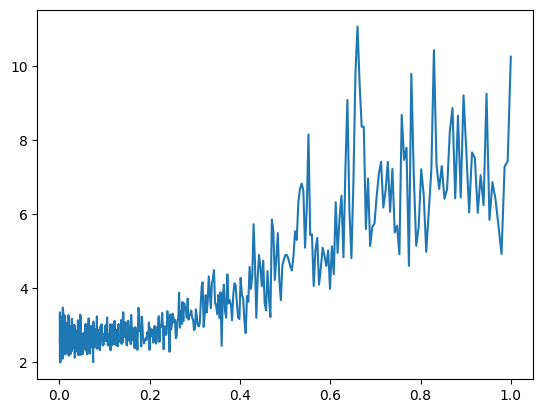

In [57]:
plt.plot(lri, lossi)

Here starting from learning rate 0.001 to 1.0 we found that the error start to decrease and then after 0.3 the error increase and become unstable so a good learning is around 0.2 to 0.3

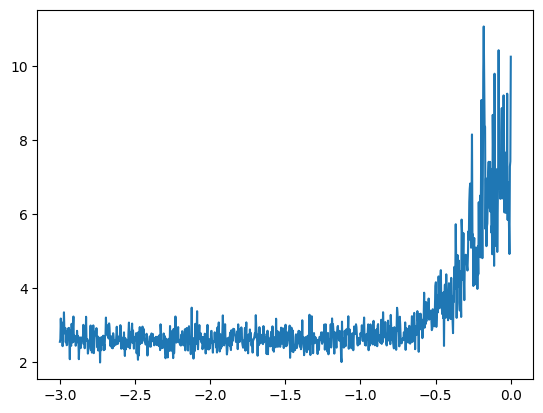

In [58]:
plt.plot(expl, lossi)

exponent with error: so around -1 there is exploding of learning rate

In [59]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [60]:
for p in parameters:
    p.requires_grad = True

for first 10000 using learning rate `0.1`

In [61]:
for i in range(1000):
    # forward propagation
    ix = torch.randint(0, X.shape[0], (32, ))
    
    embedding = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward propagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
print(loss.item())

3.2100167274475098


then for next 10000 decaying the learning rate to `0.01` we want slower update now

In [62]:
for i in range(1000):
    # forward propagation
    ix = torch.randint(0, X.shape[0], (32, ))
    
    embedding = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward propagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
print(loss.item())

2.16518497467041


In [63]:
# now further training 10000 step

for i in range(1000):
    # forward propagation
    ix = torch.randint(0, X.shape[0], (32, ))
    
    embedding = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward propagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
print(loss.item())

2.7102410793304443


But if the model complexity grows and we get the training accuracy high or get the model error low it might just be model `overfitting` that model just learn the training data and not good for test data so we split data in `train test validation` data for this purpose

### Train Test Split Data

In [64]:
block_size = 3 # context length
def build_dataset(words):  
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [65]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [66]:
for p in parameters:
    p.requires_grad = True # enable gradietn

In [67]:
for i in range(1000):
    # forward propagation
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    embedding = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward propagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
print(loss.item())

2.8936870098114014


In [68]:
# evaluation
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.9535, grad_fn=<NllLossBackward0>)

In [69]:
# evaluation
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.9541, grad_fn=<NllLossBackward0>)

Here we found `validation loss` and `train loss` are quite equal so we can say that our model is not overfitting.

In [70]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 8), generator=g)
W1 = torch.randn((24, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [71]:
for p in parameters:
    p.requires_grad = True # enable gradient

In [72]:
lri = []
lossi = []
stepi = []

In [73]:
for i in range(30000):
    # forward propagation
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    embedding = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(embedding.view(-1, 24) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward propagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    stepi.append(i)
    lossi.append(loss.item())
    
print(loss.item())

3.2879247665405273


batch size low may cause noise in training or might the embedding dimension may not able to capture all

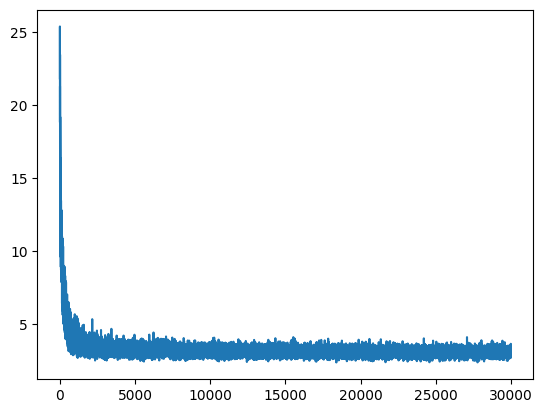

In [74]:
plt.plot(stepi, lossi)

In [75]:
# evaluation
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 24) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(3.3136, grad_fn=<NllLossBackward0>)

emb visualization

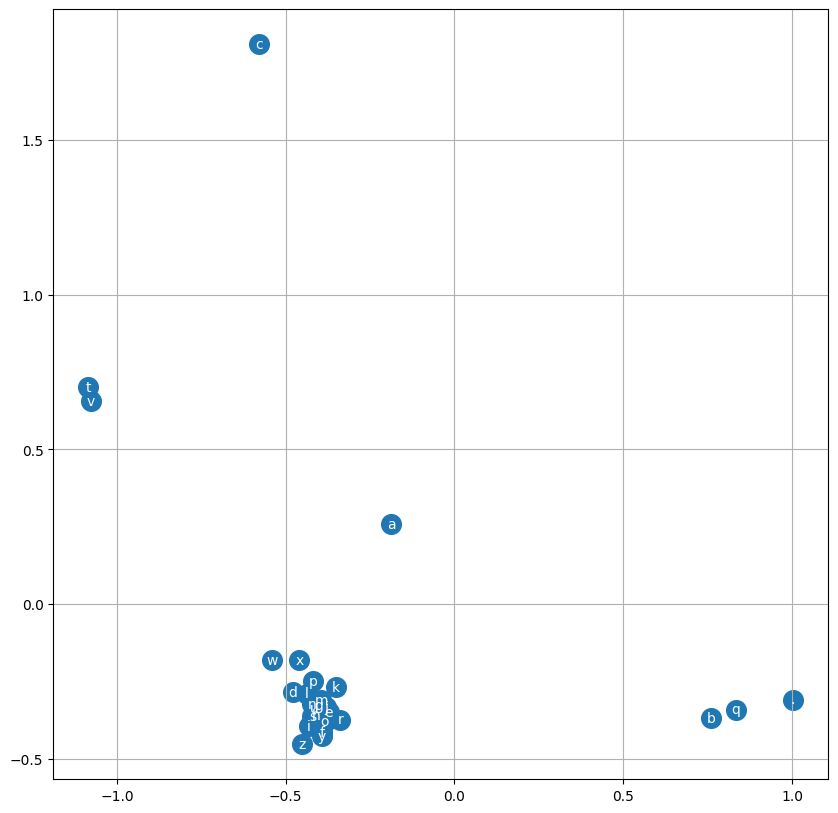

In [76]:

# visualize dimensions 0 and 1 of the embedding matrix C
plt.figure(figsize=(10, 10))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

We can further improve this model by changing `batch size` `learning rate` `hidden layer` `no of neuron`

In [77]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 8])

In [78]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

.
rn.
.
imyayhhee.
.
n.
.
nyamarehmrs.
.
ndrlmm.
.
.
e.
yd.
e.
i.
.
.
lp.
oearmieimuananarnemyzimhmkra.
